In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from source.code import ch3
from source.code import utils

2023-04-26 15:11:21.842230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 15:11:21.912950: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-26 15:11:21.928731: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-26 15:11:22.247404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
utils.gpu_limitation_config(memory=12)

2023-04-26 15:11:24.015043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 15:11:24.029671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 15:11:24.029702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


#### 1. 按下面的提示搭建`DenseNet`

1. `DenseNet` 以卷积块 `ConvBlock` 作为基础单元，请继承 `tf.keras.layers.Layer` 定义 `ConvBlock`，每个卷积块**按顺序包含三个操作**：BatchNorm，ReLU激活函数，$3\times 3$ 卷积层，卷积层使用填充，可以通过`__init__`方法控制卷积层输出的通道数量`num_channels`
      1. 假设输入 $X\in\mathbb{R}^{N\times W\times H\times c}$，经过上述三个运算后的输出 $Y\in\mathbb{R}^{N\times W\times H\times d}$，`ConvBlock` 还需要**按照稠密网络的思想，将输入和输出拼接在一起**，拼接使用`tf.concat`实现，并且需要**在通道维度上进行拼接**，因此最终输出维度是 $[X,Y]\in\mathbb{R}^{N\times W\times H\times (c+d)}$
      ```python
      class ConvBlock(tf.keras.layers.Layer):
         def __init__(self, num_channels : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
            """
            num_channels : int
               卷积层的输出通道数量
            """
            super().__init__(trainable, name, dtype, dynamic, **kwargs)
            ...
         
         def call(self, inputs, *args, **kwargs):
            ...
      ```

In [74]:
class Convblock(tf.keras.layers.Layer):
    def __init__(self,num_channels : int,  trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        """
        num_channels : int
            卷积层的输出通道数量
        """
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        #卷积层
        self.conv = tf.keras.layers.Conv2D(num_channels,kernel_size=3,padding="same")

        #batchnorm层
        self.bn = tf.keras.layers.BatchNormalization()
    
    def call(self, inputs, *args, **kwargs):
        Y = tf.keras.activations.relu(self.bn(inputs))
        Y = self.conv(Y)

        return tf.concat([inputs, Y],axis=-1)


2. 每个稠密块 `DenseBlock` 由多个卷积块 `ConvBlock` 组成，**每个卷积块使用相同数量的输出通道**，在前向推理中，我们将每个卷积块的输入和输出在通道维上连结，请继承  `tf.keras.layers.Layer` 定义 `DenseBlock`，可以通过`__init__`方法控制卷积块的数量`num_convs`
      ```python
      class DenseBlock(tf.keras.layers.Layer):
         def __init__(self, num_convs : int, num_channels : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
            """
            num_convs : int
               该稠密块包含的卷积块的数量
            num_channels : int
               每个卷积块的输出通道的数量
            """
            super().__init__(trainable, name, dtype, dynamic, **kwargs)
            ...
         
         def call(self, inputs, *args, **kwargs):
            ...
      ```

In [75]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs : int, num_channels : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        """
        num_convs : int
            该稠密块包含的卷积块的数量
        num_channels : int           
            每个卷积块的输出通道的数量
        """
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.blocks = []
        for num in range(num_convs):
            self.blocks.append(Convblock(num_channels=num_channels))
         
    def call(self, inputs, *args, **kwargs):
        for block in self.blocks:
            inputs = block(inputs)
        return inputs

3. 生成一个随机输入 $X\in\mathbb{R}^{4\times 8\times 8\times 3}$，定义一个拥有两个卷积块（`num_convs = 2`），卷积块输出通道数量为10（`num_channels = 10`）的 `DenseBlock` 实例，检验计算结果，模型的输出维度应该是 $4\times 8\times 8\times 23$

In [76]:
X = tf.random.normal([4,8,8,3])
X.shape

TensorShape([4, 8, 8, 3])

In [77]:
model = DenseBlock(2,10)
Y =model(X)
Y.shape

TensorShape([4, 8, 8, 23])

4. 由于每个稠密块都会带来通道数的增加，使用过多会让模型太复杂，定义过渡层 `TransitionBlock` 控制模型复杂度，请继承  `tf.keras.layers.Layer` 定义 `TransitionBlock`：
      1. 先进行 BatchNorm 和 ReLU 激活
      2. 通过 $1\times 1$ 卷积层来减小通道数，通道数`num_channels`可以通过`__init__`方法控制
      3. 使用尺寸为2，步幅为2的平均汇聚层减半高和宽，进一步降低模型复杂度
      ```python
      class TransitionBlock(tf.keras.layers.Layer):
         def __init__(self, num_channels : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
            """
            num_channels : int
               控制过渡层的输出通道数量
            """
            super().__init__(trainable, name, dtype, dynamic, **kwargs)
            ...
         
         def call(self, inputs, *args, **kwargs):
            ...
      ```

In [78]:
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self,num_channels : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        """
        num_channels : int
            控制过渡层的输出通道数量
        """
        super().__init__(trainable, name, dtype, dynamic, **kwargs)

        #定义batchnorm层
        self.bn = tf.keras.layers.BatchNormalization()
        #定义1*1卷积层
        self.conv11 = tf.keras.layers.Conv2D(filters=num_channels,kernel_size=1)
        #定义平均汇聚层
        self.meanpool = tf.keras.layers.AveragePooling2D(pool_size=2,strides=2,padding="same")
         
    def call(self, inputs, *args, **kwargs):
        Y = tf.keras.activations.relu(self.bn(inputs))
        Y = self.conv11(Y)
        Y = self.meanpool(Y)
        return Y

In [79]:
model2 = TransitionBlock(10)
Y2 = model2(Y)
Y2.shape

TensorShape([4, 4, 4, 10])

5. 接下来，我们定义 `DenseNet` 模型，你可以尝试用`tf.keras.models.Sequential`或者其他你喜欢的方法实现
      1. 模型第一块与 `ResNet` 相同，使用单卷积层和最大汇聚层，计算过程如下
         1. 使用尺寸为7，步幅为2，输出通道为64的卷积核，启用填充
         2. 进行 BatchNorm 和 ReLU 激活
         3. 使用尺寸为3，步幅为2的最大汇聚层，启用填充
      2. 模型第二块同样与 `ResNet` 类似，`ResNet` 使用四个残差块，`DenseNet` 使用**四个稠密快**
         1. 总共四个 `DenseBlock`，每个均设置 `num_convs = 4` 包含四个卷积块，通道数 `num_channels = 32`
         2. 请问，经过每个 `DenseBlock` 后，特征的通道数量增加多少个？
         3. 在四个  `DenseBlock` **两两之间添加三个过渡层** `TransitionBlock`，**每个过渡层负责将当前的通道数减半**
      3. 最后到分类器的部分，对最后一个 `DenseBlock` 的输出执行如下变换：
         1. 首先 BatchNorm 和 ReLU 激活
         2. 使用全局平均池化，并将特征拉直为向量
         3. 根据分类问题的类别数，设定最后的全连接层
         4. 连接`Softmax()`激活，将输出变为概率分布

练练手，熟悉类的写法，拆成几部分来写

In [80]:
class DenseNetfirst(tf.keras.Model):
    def __init__(self, num_channels, strides : int=2, use_1x1conv : bool=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 卷积层和最大汇聚层
        self.conv = tf.keras.layers.Conv2D(num_channels,kernel_size=7,padding="same",strides=strides)
        self.maxconv = tf.keras.layers.MaxPool2D(pool_size=3,strides=strides,padding="same")
        # BatchNorm层
        self.bn = tf.keras.layers.BatchNormalization()
    
    def call(self, inputs, *args, **kwargs):
        Y = self.conv(inputs)
        Y = tf.keras.activations.relu(self.bn(Y))
        Y = self.maxconv(Y)
        return Y

In [81]:
class DensNetmid(tf.keras.Model):
    def __init__(self, num_channels, num_convs : int=4, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.db = DenseBlock(num_channels=num_channels,num_convs=num_convs)
        self.tb1 =  TransitionBlock(num_channels=num_channels /2)
        self.tb2 = TransitionBlock(num_channels=num_channels /4)
        self.tb3 = TransitionBlock(num_channels=num_channels /8)

    def call(self, inputs, *args, **kwargs):
        Y = self.db(inputs)
        Y = self.tb1(Y)
        Y = self.tb2(Y)
        Y = self.tb3(Y)
        return Y

In [86]:
class Denselast(tf.keras.Model):
    def __init__(self, class_num : int, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.dense = tf.keras.layers.Dense(class_num)

    def call(self, inputs, *args, **kwargs):
        Y = tf.keras.layers.BatchNormalization()(inputs)
        Y = tf.keras.activations.relu(Y)
        Y = tf.keras.layers.GlobalAveragePooling2D()(Y)
        Y = tf.keras.layers.Flatten()(Y)
        Y = self.dense(Y)
        return tf.keras.layers.Softmax()(Y)

In [87]:
def DenseNetModel(input_shape : tuple, class_num : int=2):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(input_shape),
        DenseNetfirst(num_channels=64,strides=2),
        DensNetmid(num_channels=32,num_convs=4),
        DensNetmid(num_channels=32,num_convs=4),
        DensNetmid(num_channels=32,num_convs=4),
        DenseBlock(num_channels=32,num_convs=4),
        Denselast(class_num=class_num)
    ])

   6. 选择训练模型的合适超参数，测试模型在`CIFAR-100`上的表现

In [88]:
# 加载 CIFAR-100 数据集
(x_train,y_train), (x_test,y_test) = ch3.load_cifar100()

训练集特征形状： (50000, 32, 32, 3)
训练集标签形状： (50000, 1)


In [89]:
# 创建模型
model = DenseNetModel(input_shape=(32,32,3),class_num=100)

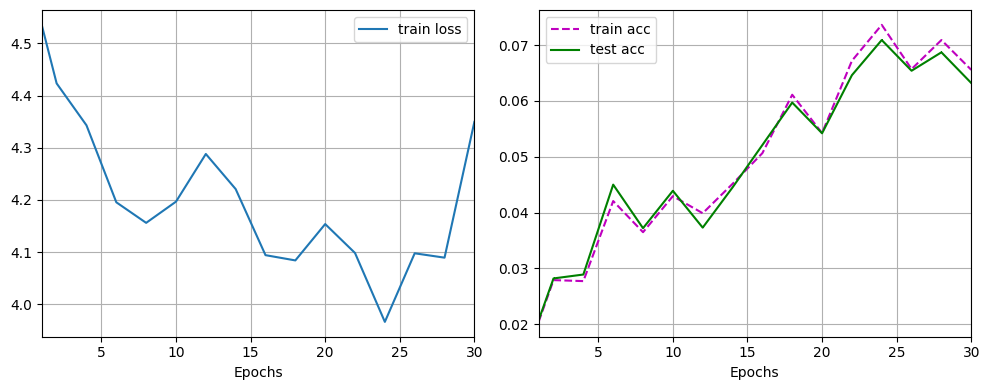

In [90]:
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=30,verbose=2,lr=0.1)

#### 2. 该练习帮助你**理解卷积神经网络的特征提取功能**
   1. 选择一个你喜欢的网络结构，例如 `LeNet`，用 `tf.keras.models.Sequential` 方法实现它
      * **确保可以获得模型中间部分卷积层的计算结果**，对于 `Sequential` 模型，`model.layers` 可以访问每一层计算层
   2. 让模型在 `Fashion-MNIST` 数据集上训练，确保模型收敛
   3. 绘制不同输入（例如毛衣和鞋子）时，网络不同卷积块层，各个通道的计算结果
      * 如果你选择的是 `LeNet`，就绘制第一层卷积和第二层卷积的输出
   4. 如果上述实现有困难，或者想更直观地理解卷积神经网络，可以访问![https://poloclub.github.io/cnn-explainer/]

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((28,28,1)),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5,activation="relu", padding="same"),
    tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=16,kernel_size=5,activation="relu"),
    tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120,activation="relu"),
    tf.keras.layers.Dense(84,activation="relu"),
    tf.keras.layers.Dense(10,activation="softmax"),
])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [5]:
#导入Fashion-MNIST数据集
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [6]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [7]:
x_train = tf.expand_dims(x_train.astype(np.float32)/255.0,axis=-1)
x_test = tf.expand_dims(x_test.astype(np.float32)/255.0,axis=-1)

In [8]:
y_train = tf.keras.utils.to_categorical(y_train,10)
y_test = tf.keras.utils.to_categorical(y_test,10)

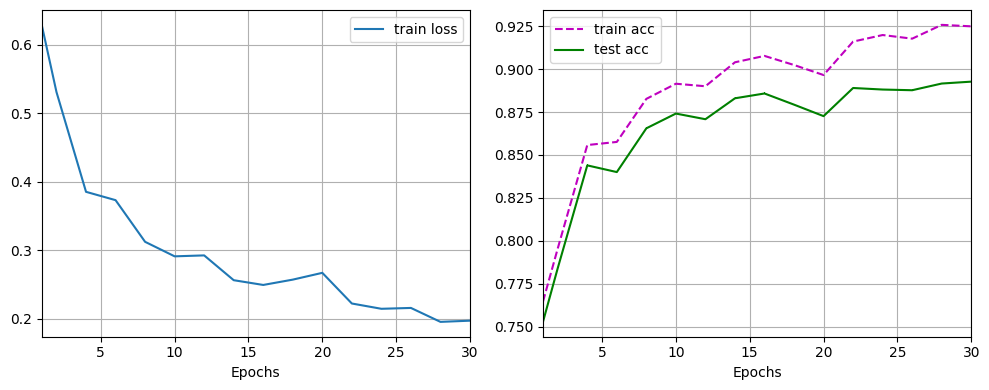

In [12]:
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                    batch_size=256,epochs=30,verbose=2,lr=0.2)

   3. 绘制不同输入（例如毛衣和鞋子）时，网络不同卷积块层，各个通道的计算结果
      * 如果你选择的是 `LeNet`，就绘制第一层卷积和第二层卷积的输出
   4. 如果上述实现有困难，或者想更直观地理解卷积神经网络，可以访问![https://poloclub.github.io/cnn-explainer/]

In [13]:
model.layers

In [14]:
first_layer =tf.keras.models.Sequential(model.layers[0:1])
second_layer =tf.keras.models.Sequential(model.layers[0:3])

In [17]:
first_layer(x_train[0:1]).shape, second_layer(x_train[0:1]).shape

(TensorShape([1, 28, 28, 6]), TensorShape([1, 10, 10, 16]))

In [18]:
def plot_conv(X: tf.Tensor, num_rows: int=2, num_cols: int=3):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1.5, num_rows * 1.5))
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(tf.squeeze(X[:,:,:,i * num_cols + j]), cmap='gray')
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

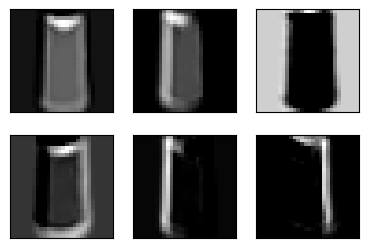

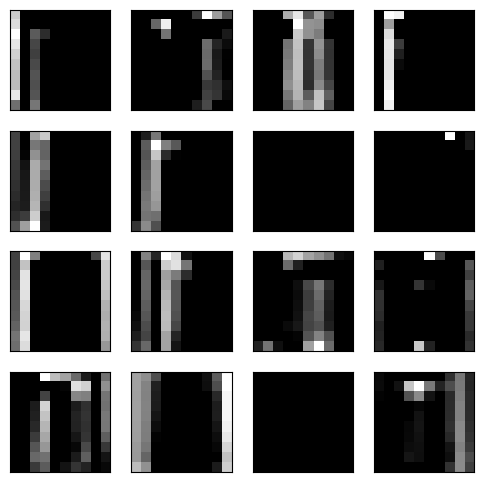

In [22]:
plot_conv(first_layer(x_train[2:3]))
plot_conv(second_layer(x_train[2:3]), num_rows=4, num_cols=4)